# Part 1 - Brief description of the problem and data

In this project, I will be creating an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans as described on the [Histopathologic Cancer Detection Kaggle project page](https://www.kaggle.com/c/histopathologic-cancer-detection/overview).

The data includes 220,025 image files named with an image `id` and a `.tif` suffix.  These image files are 96x96 pixels with an RGB color space.

It also includes a file named `train_labels.csv` with 2 columns;
1. `id`: The same id used for the image file name.  For example, the training file `0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif` corresponds to the row in the CSV file with that same number in the `id` column.
2. `label`: 0 = does not contain metastatic cancer tissue.  1 = contains metastatic cancer tissue.

# Part 2 - Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler

# Load training data
train_dir = 'train'
train_labels_file = 'train_labels.csv'
img_size = (96, 96)

# Load labels
train_labels_df = pd.read_csv(train_labels_file)
train_labels_df['filename'] = train_labels_df['id'].astype(str) + '.tif'
train_labels_df['label'] = train_labels_df['label'].astype(str)  # Convert labels to string for the generator

# Check for missing values.  If any are found, consider deleting them to clean up the data.
train_labels_df.isnull().sum()

id          0
label       0
filename    0
dtype: int64

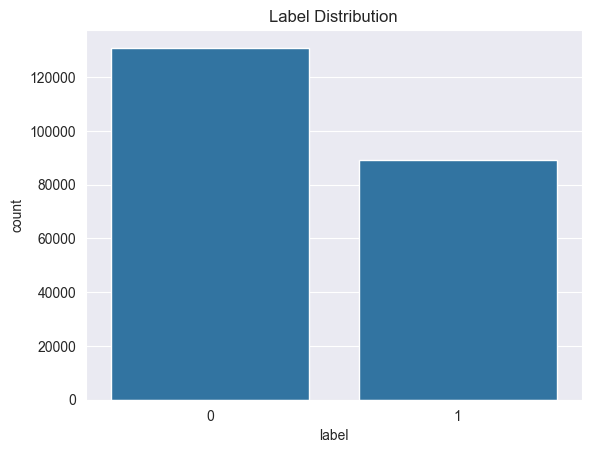

In [9]:
# Look at the distribution of the labels.  An even distribution would be best for training.  However, an imbalance is expected with many 0's and few 1's because most of the population does not have cancer.
sns.countplot(x='label', data=train_labels_df)
plt.title('Label Distribution')
plt.show()


# Part 3 - Model Architecture
## Model 1 - Base Model

Various types of convolutional neural networks (CNNs) can be used to solve this issue.  I've chosen to start with a convolutional neural network (CNN) that contains:
  1. Max pooling for dimensionality reduction.  This helps retain important features while discarding redundant details and reducing computational complexity.
  2. A dropout layer to prevent overfitting.  This randomly sets a fraction of the layer's outputs to zero during training.  This prevents the model from relying on certain neurons too heavily, which helps generalize better.

In [7]:
# Image data generator for training
train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    train_labels_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_labels_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [3]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
epochs = 5
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-17 19:26:19.407632: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-17 19:26:19.407665: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-17 19:26:19.407670: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-17 19:26:19.407697: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-17 19:26:19.407711: I tensorflow/core/common_run

In [8]:
def load_test_data_and_predict(model, output_file_name):
    test_dir = 'test'
    test_images = [f for f in os.listdir(test_dir) if f.endswith('.tif')]
    predictions = []

    for img_file in test_images:
        img_path = os.path.join(test_dir, img_file)
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        label = 1 if prediction[0][0] >= 0.5 else 0
        predictions.append((img_file.replace('.tif', ''), label))

    # Save predictions to CSV
    submission_df = pd.DataFrame(predictions, columns=['id', 'label'])
    submission_df.to_csv(output_file_name, index=False)

    print("Training complete. Predictions saved to submission.csv.")

In [ ]:
load_test_data_and_predict(model, 'submission.csv')

# Part 4 - Results and Analysis

The private/public score of my first model on Kaggle is 0.8096/0.8474.  Now I will run hyperparameter tuning and discuss what helped.

Note: Training of this model takes 13min 15sec, then it takes an additional 21min to run the model on the test data.  In total, each new model attempt that I write takes 34min 15sec to test

## Model 2 - Add 2 Dropout Layers
To start, I will add 2 more dropout layers to the model.  As a reminder, dropout layers help prevent overfitting by randomly setting a fraction of the layer's outputs to zero during training.

In [9]:
# Take model1, add 2 dropout layers
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),
    Dropout(0.2), # New in model 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2), # New in model 2
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'), # This was 128 in prev model
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

epochs = 5
history = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

load_test_data_and_predict(model2, 'submission_extra_dropout_layers.csv')

/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-18 18:28:25.646785: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-18 18:28:25.646844: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-18 18:28:25.646864: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-18 18:28:25.647118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-18 18:28:25.647139: I tensorflow/core/common_run

## Model 3 - Add a Learning Rate Scheduler
Next I will create a model identical to the previous one, but this time I will add a **learning rate schedule** that decreases the learning rate in later epochs.  This allows large updates to the model at the beginning to reduce loss, but then slows the learning rate later to reduce the risk of overshooting the optimum.

In [8]:
def lr_schedule(epoch, lr):
    if epoch > 2:
        return lr * 0.5
    return lr

callbacks = [LearningRateScheduler(lr_schedule)]

# Make a copy of model 2
model3 = model2

history = model3.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=callbacks
)

load_test_data_and_predict(model3, 'submission_lr_schedule.csv')

Epoch 1/5


/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-17 13:58:01.857246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 187s 34ms/step - accuracy: 0.7531 - loss: 0.5120 - val_accuracy: 0.8034 - val_loss: 0.4301 - learning_rate: 0.0010
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 240s 44ms/step - accuracy: 0.8495 - loss: 0.3558 - val_accuracy: 0.8669 - val_loss: 0.3108 - learning_rate: 0.0010
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 216s 39ms/step - accuracy: 0.8715 - loss: 0.3100 - val_accuracy: 0.8817 - val_loss: 0.2794 - learning_rate: 0.0010
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 211s 38ms/step - accuracy: 0.8917 - loss: 0.2667 - val_accuracy: 0.9065 - val_loss: 0.2448 - learning_rate: 5.0000e-04
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 210s 38ms/step - accuracy: 0.9014 - loss: 0.2433 - val_accuracy: 0.9057 - val_loss: 0.2353 - learning_rate: 2.5000e-04


## Model 4 - Increase Number of Filters in Convolutional Layers
This next model will be identical to model 2, but it will double the number of filters used in each of the 3 convolutional layers.

In [ ]:
model4 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)), # model 1 uses 32 filters on this layer, and it uses 64 and 128 filters for the next 2 layers
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'), # model 1 uses 128
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model4.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

epochs = 5
history = model4.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

load_test_data_and_predict(model4, 'submission3.csv')

Epoch 1/5


/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-18 18:30:46.977146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 405s 73ms/step - accuracy: 0.7795 - loss: 0.4758 - val_accuracy: 0.8377 - val_loss: 0.3701
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 437s 79ms/step - accuracy: 0.8542 - loss: 0.3449 - val_accuracy: 0.8458 - val_loss: 0.3551
Epoch 3/5
1751/5501 ━━━━━━━━━━━━━━━━━━━━ 4:47 77ms/step - accuracy: 0.8667 - loss: 0.3178

## Model 5 - Lower Learning Rate
This model is identical to model 2, but with a lower learning rate of 0.0001.  The original model used a learning rate of 0.001 (10x higher than this new model).

In [6]:
model5 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model5.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

epochs = 5
history = model5.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

load_test_data_and_predict(model5, 'submission_smaller_lr.csv')

/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/.venv1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Analysis and comparison of 5 models
After running the submission CSV files generated above through Kaggle, Kaggle provided private and public scores for each.  I've documented these below.  I tested 5 models total.

Both the public and private scores matter, but the private score is considered as the true measure of the model's performance.  The public score is computed using the test dataset provided, while the private score is computed using a dataset that Kaggle does not share.  It is possible to achieve a high public score by overfitting the public dataset, and then get a lower private score.


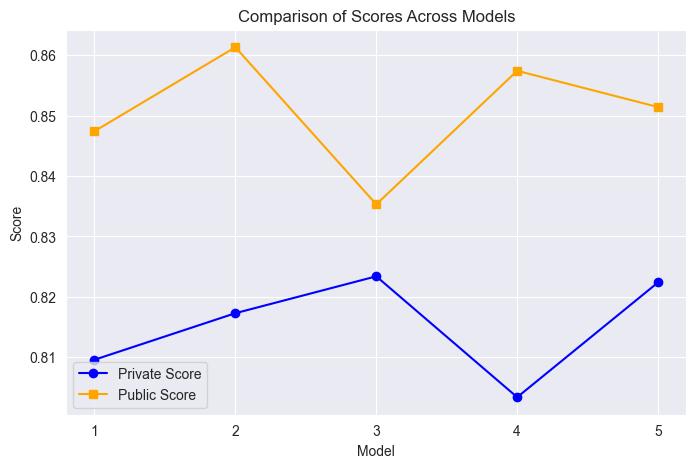

In [3]:
results = [[0.8096, 0.8474], [0.8173, 0.8613], [0.8234, 0.8353], [0.8034, 0.8574], [0.8224, 0.8514]]

# Separate the pairs into two lists
x_values = range(1, len(results) + 1)  # X-axis values as indices
y1_values = [pair[0] for pair in results]
y2_values = [pair[1] for pair in results]

# Plotting the graph
plt.figure(figsize=(8, 5))
plt.plot(x_values, y1_values, marker='o', label="Private Score", color='blue')
plt.plot(x_values, y2_values, marker='s', label="Public Score", color='orange')

# Adding labels, title, and legend
plt.title("Comparison of Scores Across Models")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(ticks=x_values)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

**The highest private score was achieved with model 3**, which used a learning rate scheduler to decrease the learning rate by half starting at epoch 3.

Model 2, which added dropout layers to model 1, had better public and private scores as compared to model 1 and achieved the highest public score of all models I tested.  Despite model 3 having a lower public score than model 2, the private score was higher.  This suggests that model 2 may have overfit the data, while model 3 was able to generalize better.

Before I conclude and elect model 3 as the best-performing model, I will try one last model.

## Model 6 - Model 3 but with 10 epochs instead of 5

I have consistently used 5 epochs to train each model above.  I will now take my highest-performing model (model 3), and retrain it with 10 epochs instead of 5.

In [ ]:
# Make a copy of model 3
model6 = model3

history = model6.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

load_test_data_and_predict(model6, 'submission_lr_schedule_10_epochs.csv')

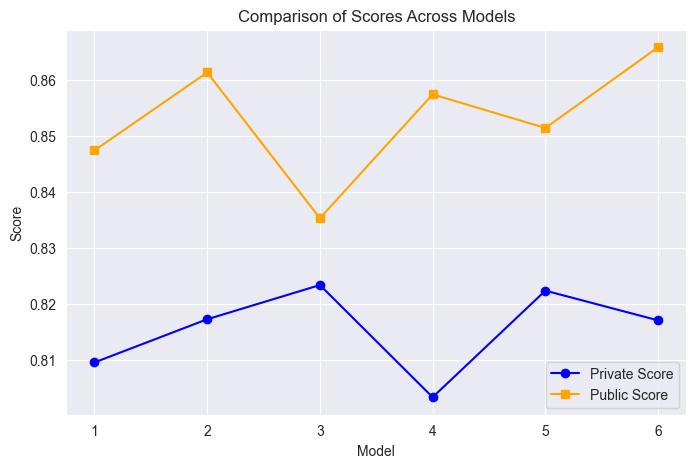

In [4]:
results.append([0.8171, 0.8658])

# Separate the pairs into two lists
x_values = range(1, len(results) + 1)  # X-axis values as indices
y1_values = [pair[0] for pair in results]
y2_values = [pair[1] for pair in results]

# Plotting the graph
plt.figure(figsize=(8, 5))
plt.plot(x_values, y1_values, marker='o', label="Private Score", color='blue')
plt.plot(x_values, y2_values, marker='s', label="Public Score", color='orange')

# Adding labels, title, and legend
plt.title("Comparison of Scores Across Models")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(ticks=x_values)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Step 5 - Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

I trained 6 models total:
1. Base model: 3 convolutional blocks with an increasing number of filters in each (32, 64, 128)
2. Base model + 2 dropout layers
3. Base model + 2 dropout layers + learning rate scheduler
4. Base model + 2 dropout layers + double filter count in each convolutional block
5. Base model + 2 dropout layers + lower learning rate
6. Base model + 2 dropout layers + learning rate scheduler + 10 epochs (instead of 5)

The public and private accuracy increased going from model 1 to model 2, so I kept the 2 additional dropout layers in the rest of the models.  Then in the 3rd model, which added the learning rate scheduler, the public accuracy decreased but the private increased.  Model 4 increased the number of filters from model 2, but the impact on the public score was negative while the private score stayed roughly the same.  Model 5 lowered the learning rate from model 2, but that had minimal impact on the accuracies.  Lastly, model 6 doubled the number of training epochs from model 3, which caused the model to overfit (increased public accuracy, decreased private accuracy).

In the future, I could try the following to further improve the accuracy:
1. Adding more convolutional layers to capture finer detail
2. Using a pre-trained model
3. Varying the number of epochs